# Predictive Model of Airbnb data

## Overview
In this analysis, we build a predictive model to estimate the potential revenue of properties when adapted for long-term rentals to small businesses. With the new regulations in place, property owners are seeking alternative strategies to maintain profitability, and renting out properties to small businesses presents a promising solution.

## Objective
The objective of this notebook is to:

- Develop a predictive model that estimates the revenue potential for properties adapted to small business rentals.


## Approach
To achieve this, we will:

1. Use historical Airbnb property data, which includes features like price, property type, reviews, occupancy rate, and location.
2. Build a regression model (Gradient Boosting) to predict the revenue potential of properties based on these features.

This analysis aims to provide a data-driven recommendation for property owners, helping them assess the revenue potential of shifting to long-term rentals for small businesses under the current regulatory framework.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

# from category_encoders import TargetEncoder


import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [3]:
df = pd.read_csv("effects-of-policy-on-the-housing-market/train.csv")
df.head()


,Unnamed: 0.1,Unnamed: 0,id,name,neighborhood_overview,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,monthly_revenue
0,0,879,19792418,Home in Vancouver · ★4.75 · 1 bedroom · 1 bed ...,Everything you need is nearby. <br /><br />Hig...,57488206,Jessi,NaN,NaN,NaN,...,4.80,4.82,4.90,4.87,4.69,4.81,f,3,0.77,2108
1,1,6416,1015650685503221866,Guest suite in Vancouver · ★New · 2 bedrooms ·...,NaN,139792573,Daniel,within a few hours,100%,100%,...,NaN,NaN,NaN,NaN,NaN,NaN,f,1,NaN,2730
2,2,1820,35265562,Guest suite in Vancouver · ★4.85 · 2 bedrooms ...,Beautiful neighbourhood close to prosperous Ma...,265504225,Alex,within an hour,100%,98%,...,4.90,4.78,4.97,4.94,4.90,4.75,f,1,3.22,2254
3,3,5346,911948980885194155,Home in Vancouver · ★5.0 · 1 bedroom · 1 bed ·...,We are located in a quiet residential neighbor...,22595056,Raymond,NaN,NaN,92%,...,5.00,5.00,5.00,5.00,4.86,5.00,f,1,1.28,3187
4,4,2484,46069251,Guest suite in Vancouver · ★4.93 · 1 bedroom ·...,Kitsilano at it's best! Short walk to all the ...,65683877,Yendi,within an hour,100%,95%,...,4.93,4.89,4.97,4.97,4.96,4.85,f,1,2.01,3479


In [4]:
# Check data structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0.1                    5352 non-null   int64  
 1   Unnamed: 0                      5352 non-null   int64  
 2   id                              5352 non-null   int64  
 3   name                            5352 non-null   object 
 4   neighborhood_overview           3476 non-null   object 
 5   host_id                         5352 non-null   int64  
 6   host_name                       5352 non-null   object 
 7   host_response_time              4263 non-null   object 
 8   host_response_rate              4263 non-null   object 
 9   host_acceptance_rate            4620 non-null   object 
 10  host_is_superhost               5315 non-null   object 
 11  host_listings_count             5352 non-null   int64  
 12  host_total_listings_count       53

## Explore and understand the dataset

In [5]:
missing_cols = df.columns[df.isnull().any()]
print(f"Columns with missing values: {missing_cols}")

Columns with missing values: Index(['neighborhood_overview', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'beds',
       'price', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')


In [6]:
df[['neighborhood_overview', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'beds',
       'price', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   neighborhood_overview        3476 non-null   object 
 1   host_response_time           4263 non-null   object 
 2   host_response_rate           4263 non-null   object 
 3   host_acceptance_rate         4620 non-null   object 
 4   host_is_superhost            5315 non-null   object 
 5   neighbourhood                3476 non-null   object 
 6   beds                         5316 non-null   float64
 7   price                        4687 non-null   object 
 8   review_scores_rating         4452 non-null   float64
 9   review_scores_accuracy       4452 non-null   float64
 10  review_scores_cleanliness    4452 non-null   float64
 11  review_scores_checkin        4451 non-null   float64
 12  review_scores_communication  4452 non-null   float64
 13  review_scores_loca

We see that these are the values missing in the dataset, instead of simply imputing values, since no reviews essentially means the property is new, let's introduce a new column saying whether the property has reviews or not. 

In [7]:
# Create a new column 'has_reviews' (1 if there is a review, 0 if not)
df['has_reviews'] = df['review_scores_rating'].notnull().astype(int)

 We also see that price, neighborhood and neighbourhood overview is missing. For neighborhood and neighborhood overview, we can use blanks since we don't want to replace it with the wrong location. For price, maybe we can replace it with the average price of the neighborhood of the place (if it exists) else unknown. 

In [8]:
# Replace missing values in 'neighbourhood' with 'unknown'
df['neighbourhood'].fillna('', inplace=True)
df['name'].fillna('', inplace=True)
df['neighborhood_overview'].fillna('', inplace=True)


In [9]:
# Remove non-numeric characters (like $ and commas) and convert the column to numeric
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # Converts any non-numeric values to NaN

# Calculate the average price for each neighborhood
neighbourhood_avg_price = df.groupby('neighbourhood')['price'].mean()

# Define a function to fill missing price values
def impute_price(row):
    if pd.isna(row['price']):
        # If price is missing, use the average price of the neighborhood
        if row['neighbourhood'] in neighbourhood_avg_price:
            return neighbourhood_avg_price[row['neighbourhood']]
        else:
            # If no price data is available for the neighborhood, return NaN
            return None
    else:
        return row['price']

# Apply the function to fill missing price values
df['price'] = df.apply(impute_price, axis=1)


In [10]:
df.head()

,Unnamed: 0.1,Unnamed: 0,id,name,neighborhood_overview,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,monthly_revenue,has_reviews
0,0,879,19792418,Home in Vancouver · ★4.75 · 1 bedroom · 1 bed ...,Everything you need is nearby. <br /><br />Hig...,57488206,Jessi,NaN,NaN,NaN,...,4.82,4.90,4.87,4.69,4.81,f,3,0.77,2108,1
1,1,6416,1015650685503221866,Guest suite in Vancouver · ★New · 2 bedrooms ·...,,139792573,Daniel,within a few hours,100%,100%,...,NaN,NaN,NaN,NaN,NaN,f,1,NaN,2730,0
2,2,1820,35265562,Guest suite in Vancouver · ★4.85 · 2 bedrooms ...,Beautiful neighbourhood close to prosperous Ma...,265504225,Alex,within an hour,100%,98%,...,4.78,4.97,4.94,4.90,4.75,f,1,3.22,2254,1
3,3,5346,911948980885194155,Home in Vancouver · ★5.0 · 1 bedroom · 1 bed ·...,We are located in a quiet residential neighbor...,22595056,Raymond,NaN,NaN,92%,...,5.00,5.00,5.00,4.86,5.00,f,1,1.28,3187,1
4,4,2484,46069251,Guest suite in Vancouver · ★4.93 · 1 bedroom ·...,Kitsilano at it's best! Short walk to all the ...,65683877,Yendi,within an hour,100%,95%,...,4.89,4.97,4.97,4.96,4.85,f,1,2.01,3479,1


The missing values in the beds column (a numerical feature) are replaced with the median number of beds across the dataset.
The median is used instead of the mean because it is less sensitive to extreme values (outliers), ensuring a more robust fill strategy.

In [11]:
median_beds = df['beds'].median()
df['beds'].fillna(median_beds, inplace=True)


### Feature Engineering

Now that we have dealt with all missing values, let's see what new features we can add to make valuable insights. 
- We can calculate the price per bed to see how expensive the listing is relative to its capacity.
- We can can create features based on whether the price is above or below the mean for similar listings or the neighborhood. 
- A ratio of the actual guest occupancy to the maximum capacity can show how efficiently the space is being utilized.

Let's put everything within one function so that we can use this later one in the pipeline for our test data. 

In [12]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Create a new column 'has_reviews' (1 if there is a review, 0 if not)
        X['has_reviews'] = X['review_scores_rating'].notnull().astype(int)

        # Replace missing values in 'neighbourhood' with 'unknown'
        X['neighbourhood'].fillna('Unknown', inplace=True)
        X['name'].fillna('', inplace=True)
        X['neighborhood_overview'].fillna('', inplace=True)

        # Remove non-numeric characters (like $ and commas) and convert the column to numeric
        X['price'] = X['price'].replace({'\$': '', ',': ''}, regex=True)
        X['price'] = pd.to_numeric(X['price'], errors='coerce')  # Converts any non-numeric values to NaN

        #  Calculate the average price for each neighborhood
        neighbourhood_avg_price = X.groupby('neighbourhood')['price'].mean()

        # Define a function to fill missing price values
        def impute_price(row):
            if pd.isna(row['price']):
                # If price is missing, use the average price of the neighborhood
                if row['neighbourhood'] in neighbourhood_avg_price:
                    return neighbourhood_avg_price[row['neighbourhood']]
                else:
                    # If no price data is available for the neighborhood, return NaN
                    return None
            else:
                return row['price']

        # Apply the function to fill missing price values
        X['price'] = X.apply(impute_price, axis=1)

        # Impute missing beds with median value
        median_beds = X['beds'].median()
        X['beds'].fillna(median_beds, inplace=True)

        # Calculate price per bed
        X['price_per_bed'] = X['price'] / X['beds']

        # Group by neighborhood and calculate the median price in each neighborhood
        median_prices_by_neighbourhood = X.groupby('neighbourhood_cleansed')['price'].mean()

        # Map the median prices to each row based on the neighborhood
        X['neighbourhood_mean_price'] = X['neighbourhood_cleansed'].map(median_prices_by_neighbourhood)

        # Create a binary feature indicating whether the listing price is above the neighborhood median
        X['price_above_neighbourhood_average'] = (X['price'] > X['neighbourhood_mean_price']).astype(int)

        # Calculate occupancy rate
        X['occupancy_rate'] = X['beds'] / X['accommodates']

        # Calculate the length of the listing's name
        X['name_length'] = X['name'].apply(lambda x: len(str(x)))
        
        X['host_acceptance_rate'] = X['host_acceptance_rate'].replace({'%': '', ',': ''}, regex=True)
        X['host_response_rate'] = X['host_response_rate'].replace({'%': '', ',': ''}, regex=True)

        # Convert to numeric, coercing errors into NaN if they can't be converted
        X['host_acceptance_rate'] = pd.to_numeric(X['host_acceptance_rate'], errors='coerce')
        X['host_response_rate'] = pd.to_numeric(X['host_response_rate'], errors='coerce')
        
        return X

feature_engineering = FeatureEngineering()


In [13]:
df = feature_engineering.fit_transform(df)

## Exploratory Data Analysis

Now that we have this, we can start by analysing some of the features.

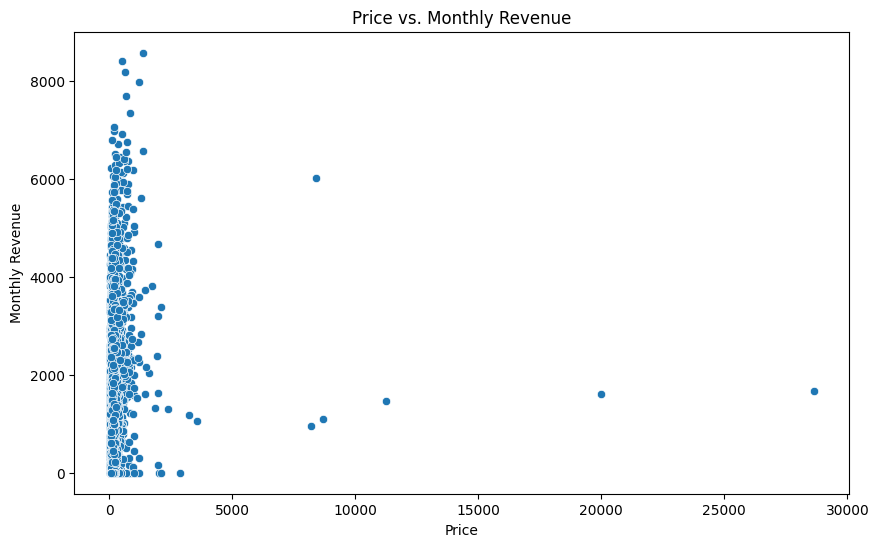

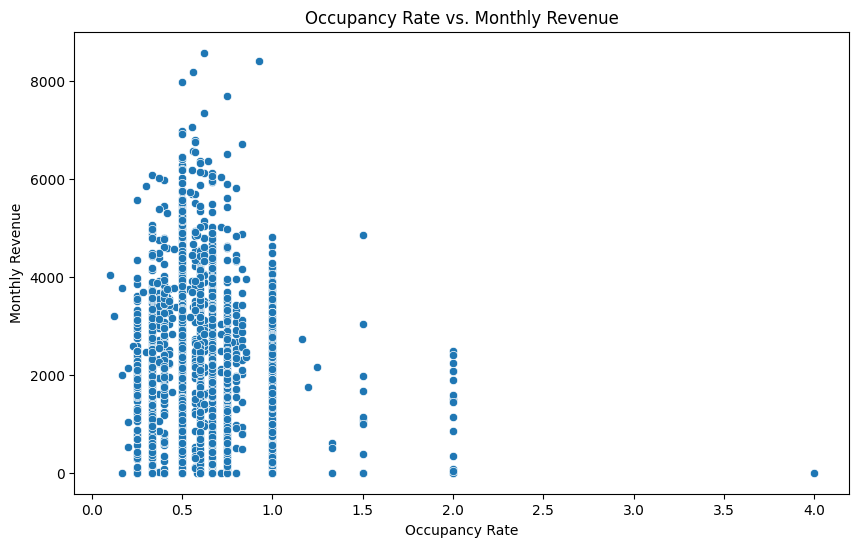

In [14]:
# Scatter plot for price vs. monthly revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='monthly_revenue', data=df)
plt.title('Price vs. Monthly Revenue')
plt.xlabel('Price')
plt.ylabel('Monthly Revenue')
plt.show()

# Scatter plot for occupancy rate vs. monthly revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='occupancy_rate', y='monthly_revenue', data=df)
plt.title('Occupancy Rate vs. Monthly Revenue')
plt.xlabel('Occupancy Rate')
plt.ylabel('Monthly Revenue')
plt.show()


From these insights, we observe that high-revenue properties often operate with lower occupancy rates, suggesting that they achieve higher rental rates. By targeting long-term clients, such properties can further benefit from consistent income streams, as business tenants or long-term renters typically offer stability. This shift to long-term rentals could also reduce turnover-related costs while maintaining or even increasing overall profitability

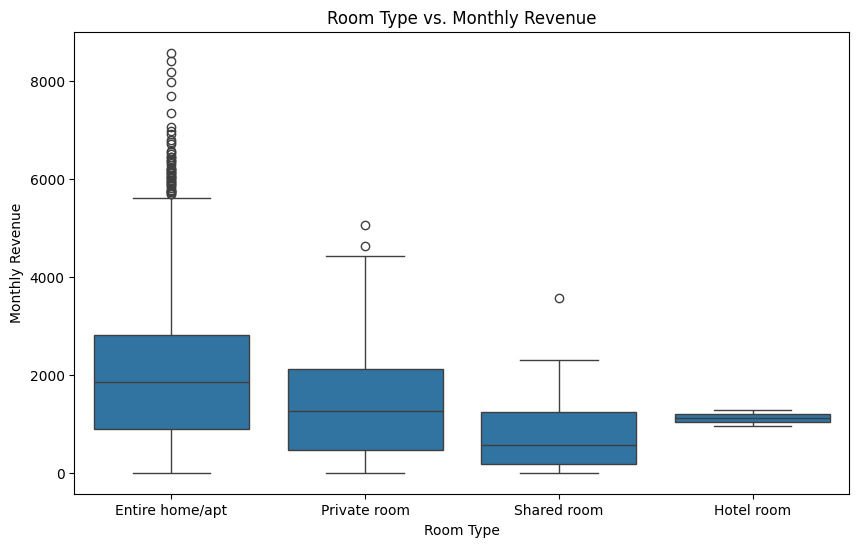

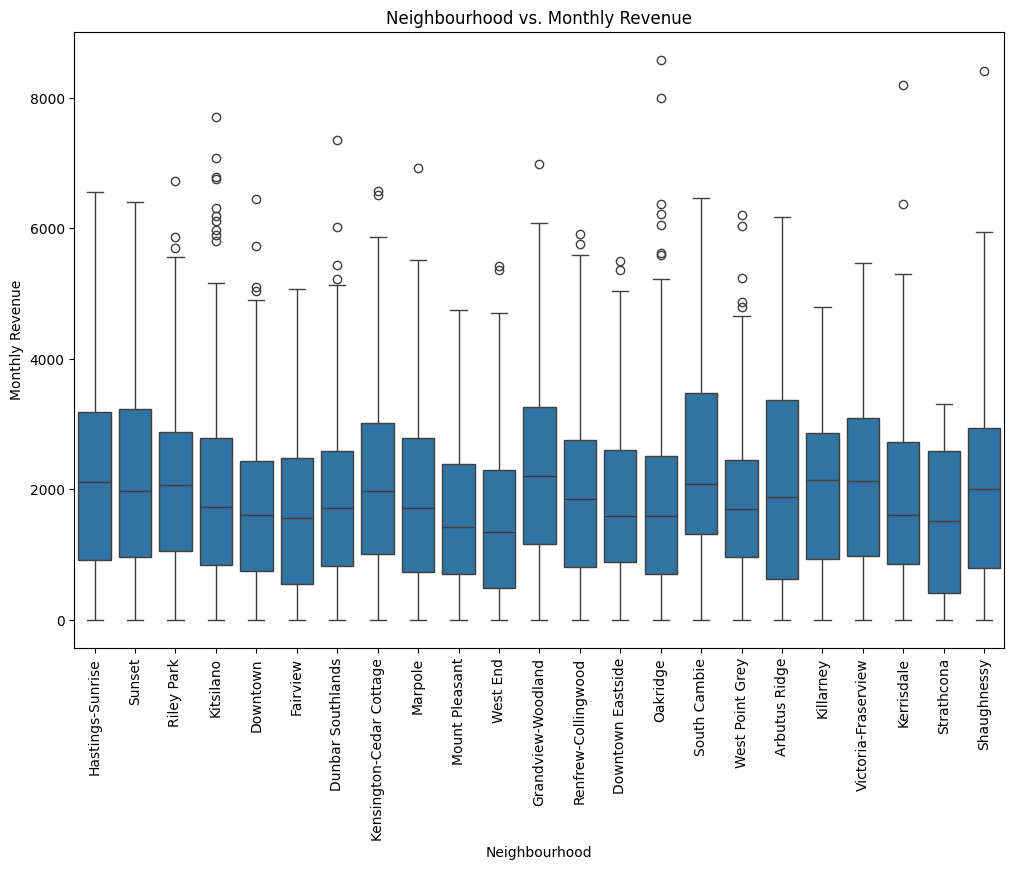

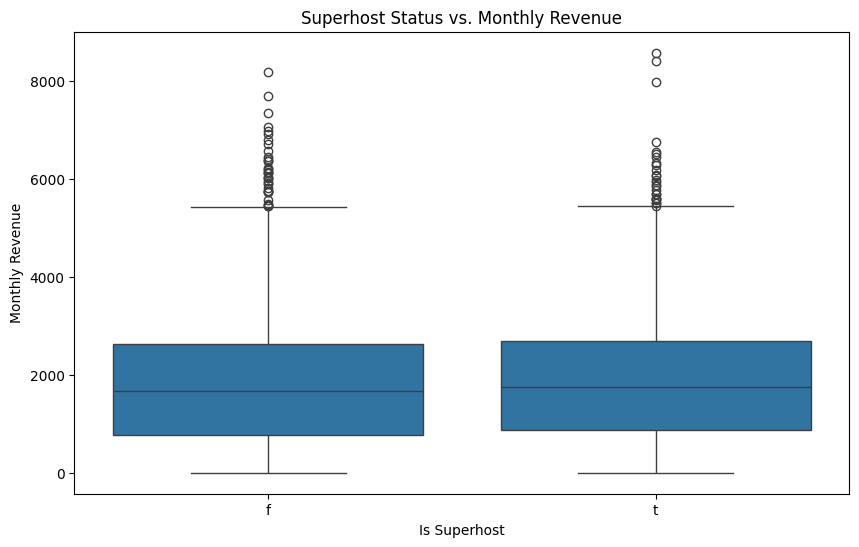

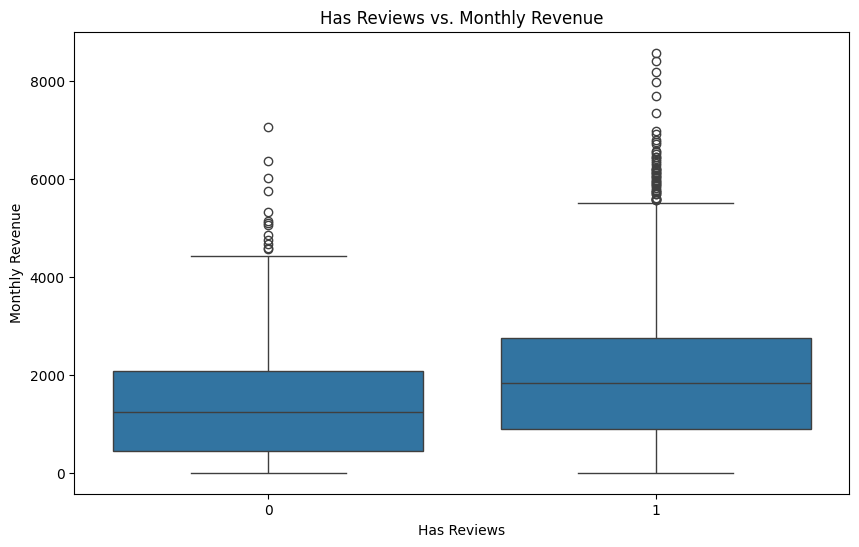

In [15]:
# Boxplot for room type vs. monthly revenue
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='monthly_revenue', data=df)
plt.title('Room Type vs. Monthly Revenue')
plt.xlabel('Room Type')
plt.ylabel('Monthly Revenue')
plt.show()

# Boxplot for neighbourhood vs. monthly revenue
plt.figure(figsize=(12, 8))
sns.boxplot(x='neighbourhood_cleansed', y='monthly_revenue', data=df)
plt.xticks(rotation=90)
plt.title('Neighbourhood vs. Monthly Revenue')
plt.xlabel('Neighbourhood')
plt.ylabel('Monthly Revenue')
plt.show()

# Boxplot for Superhost status vs. monthly revenue
plt.figure(figsize=(10, 6))
sns.boxplot(x='host_is_superhost', y='monthly_revenue', data=df)
plt.title('Superhost Status vs. Monthly Revenue')
plt.xlabel('Is Superhost')
plt.ylabel('Monthly Revenue')
plt.show()


# Boxplot for Reviews vs. monthly revenue
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_reviews', y='monthly_revenue', data=df)
plt.title('Has Reviews vs. Monthly Revenue')
plt.xlabel('Has Reviews')
plt.ylabel('Monthly Revenue')
plt.show()


Additionally, properties listed as entire homes tend to generate higher revenue, likely due to the premium prices they command. With longer-term rentals, entire homes could further capitalize on this trend by attracting stable tenants seeking more space and privacy

## Predictive Modeling

Now that we have a few insights, let's start building our model, by first splitting data into training and validation sets. 

In [16]:
X = df.drop(columns=['monthly_revenue'])  
y = df['monthly_revenue']  

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


We will now introduce our specific columns to be used in the preprocessor. 

In [17]:
# Binary Categorical Features
binary_categorical_cols = [
    'host_is_superhost',
    'instant_bookable',
    'price_above_neighbourhood_average'
]

# Multi-Categorical Features
multi_categorical_cols = [
    'neighbourhood_cleansed',
    'property_type',
    'room_type'
]

# Numerical Features
numerical_cols = [
    'minimum_nights',
    'maximum_nights',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'calculated_host_listings_count',
    'reviews_per_month',
    'latitude',
    'longitude',
    'name_length',
    'price',
    'price_per_bed',
    'occupancy_rate', 
    'neighbourhood_mean_price'
]

In [18]:
# Preprocessing for numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with mean
    ('scaler', StandardScaler())  # Scale features
])

# Preprocessing for binary categorical data
binary_categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with mode
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))  # One-hot encode binary
])

# Preprocessing for multi-class categorical data
multi_categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with mode
    ('target_encoder', TargetEncoder())  # Target encoding for multi-class features
])

text_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('vectorizer', CountVectorizer(stop_words='english', max_features=500))
])

In [19]:
# Combine pipelines in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('binary_cat', binary_categorical_pipeline, binary_categorical_cols),
        ('multi_cat', multi_categorical_pipeline, multi_categorical_cols)
    ]
)

In [20]:
def full_pipeline(model):
    return Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

Let's find the best model for our use using cross validation scores over different models.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Step 1: Define a list of models to test
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Support Vector Regressor', SVR()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42))
]

# Step 2: Create an empty dictionary to store the results
model_performance = {}

# Step 3: Iterate over the models and train them
for model_name, model in models:
    print(f"Training {model_name}...")
    
    # Create the pipeline for the model
    pipeline = full_pipeline(model)
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = pipeline.predict(X_val)
    
    # Calculate Mean Squared Error (MSE) on the validation data
    mse = mean_squared_error(y_val, y_pred)
    
    # Store the model and its performance
    model_performance[model_name] = {
        'model': model,
        'mse': mse,
        'validation_score': pipeline.score(X_val, y_val)
    }

# Step 4: Print the performance of each model
for model_name, results in model_performance.items():
    print(f"\n{model_name}:")
    print(f"Mean Squared Error: {results['mse']}")
    print(f"Validation Score: {results['validation_score']}")


Training Linear Regression...
Training Random Forest...
Training Support Vector Regressor...
Training Decision Tree...
Training Gradient Boosting Regressor...

Linear Regression:
Mean Squared Error: 1252146.4949108565
Validation Score: 0.22884777753035979

Random Forest:
Mean Squared Error: 1286067.5847810055
Validation Score: 0.20795699202860407

Support Vector Regressor:
Mean Squared Error: 1548546.4713672625
Validation Score: 0.046305637682275025

Decision Tree:
Mean Squared Error: 2686119.8132586367
Validation Score: -0.6542850794479935

Gradient Boosting Regressor:
Mean Squared Error: 1215494.6703262855
Validation Score: 0.2514203248327994


We see here that Gradient Boosting Regressor seems to work the best so we will use that.

In [22]:
pipeline = full_pipeline(GradientBoostingRegressor(random_state=42))

pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['minimum_nights',
                                                   'maximum_nights',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'number_of_reviews',
                                                   'review_scores_...
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['host_is_superhost',
                                                   'instant_bookable',
                                                   'price_above_neighbourhood_average']),
                                                 ('multi_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['neighbourhood_cleansed',
                                                   'property_type',
                                                   'room_type'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

### Feature Importance

Now that we have our model, we can fine-tune what features to use to avoid overfitting our data. 

In [23]:
feature_names = preprocessor.get_feature_names_out()

# Get feature importances
importances = pipeline.named_steps['regressor'].feature_importances_

# Extract feature names from the ColumnTransformer
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if transformer == 'passthrough':  # Columns passed directly
        feature_names.extend(columns)
    else:  # Encoded or transformed columns
        try:
            feature_names.extend(transformer.get_feature_names_out(columns))
        except AttributeError:
            feature_names.extend([f"{name}__{col}" for col in columns])


# Combine feature names and importances
feature_importances = sorted(
    zip(feature_names, importances), 
    key=lambda x: x[1], 
    reverse=True
)

for name, importance in feature_importances[:20]:  
    print(f"Feature: {name}, Importance: {importance}")



Feature: 1, Importance: 0.4764430759387396
Feature: price, Importance: 0.1296846817617096
Feature: price_per_bed, Importance: 0.10359518322438493
Feature: number_of_reviews, Importance: 0.041298557632812816
Feature: reviews_per_month, Importance: 0.02885612032417267
Feature: review_scores_rating, Importance: 0.02294728858835055
Feature: occupancy_rate, Importance: 0.022807942145444134
Feature: longitude, Importance: 0.020338701591438458
Feature: review_scores_value, Importance: 0.01975698543546306
Feature: latitude, Importance: 0.014584066564700713
Feature: availability_365, Importance: 0.013521430598744872
Feature: maximum_nights, Importance: 0.013335896355190535
Feature: price_above_neighbourhood_average_1, Importance: 0.01131395441099407
Feature: review_scores_cleanliness, Importance: 0.011159663243062962
Feature: review_scores_communication, Importance: 0.009482069681830664
Feature: review_scores_accuracy, Importance: 0.009156696455542455
Feature: name_length, Importance: 0.0082359

Based on the top 20 features, we'll focus on these for our prediction model and adjust our columns accordingly. While there are multiple review-related columns, it would be more efficient to consolidate them into one or two key metrics that provide an overview of the reviews. To streamline the data, we will retain the review_scores_rating and review_scores_value as they offer a broader summary. Additionally, we will keep the host_acceptance_rate and host_response_rate, as these are crucial for understanding the property owner's behavior and responsiveness

In [24]:
# Binary Categorical Features
binary_categorical_cols_new = [
    'price_above_neighbourhood_average'
]

# Multi-Categorical Features
multi_categorical_cols_new = [
    'property_type',
]

# Numerical Features
numerical_cols_new = [
    'host_acceptance_rate',
    'host_response_rate',
    'minimum_nights',
    'maximum_nights',
    'availability_365',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_value',
    'reviews_per_month',
    'latitude',
    'longitude',
    'name_length',
    'price',
    'price_per_bed',
    'occupancy_rate'
]

In [25]:
# Combine pipelines in a ColumnTransformer
preprocessor_new = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_new),
        ('binary_cat', binary_categorical_pipeline, binary_categorical_cols_new),
        ('multi_cat', multi_categorical_pipeline, multi_categorical_cols_new)
    ]
)

In [26]:
def final_pipeline(model):
    return Pipeline([
        ('feature_engineering', feature_engineering),
        ('preprocessor', preprocessor_new),
        ('regressor', model)
    ])

## Hyperparameter Tuning

Now that we have our features and model, let's see what hyperparameters work best with our model

In [27]:
model = GradientBoostingRegressor(random_state=42)

pipeline = final_pipeline(model)
# Define the parameter grid to search over
param_grid = {
    'regressor__n_estimators': [100, 150],
    'regressor__learning_rate': [0.1, 0.05],
    'regressor__max_depth': [3, 4],
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score from cross-validation
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score (on training data): {grid_search.best_score_}")

# Now, evaluate the best model on the validation data
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)

print(f"Validation score: {val_score}")


Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best score (on training data): 0.27647383891575494
Validation score: 0.25400347347019236


Now that we have the best hyperparameters, let's fill it in our regressor:

In [28]:
# Best parameters found from GridSearchCV
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100
}

# Create a new GradientBoostingRegressor with the best parameters
regressor = GradientBoostingRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

pipeline = Pipeline([
    ('feature_engineering', feature_engineering),
    ('preprocessor', preprocessor_new),
    ('regressor', regressor)
])

pipeline.fit(X, y)

Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['host_acceptance_rate',
                                                   'host_response_rate',
                                                   'minimum_nights',
                                                   'maximum_nights',
                                                   'availability_365',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'r...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['price_above_neighbourhood_average']),
                                                 ('multi_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder())]),
                                                  ['property_type'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

## Testing the model on test data

In [29]:
test_df = pd.read_csv("effects-of-policy-on-the-housing-market/test.csv")

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

test_df = pd.read_csv("effects-of-policy-on-the-housing-market/test.csv")
# print(test_df.columns)


predictions = pipeline.predict(test_df)

# Create a new DataFrame with only 'id' and 'monthly_Revenue' prediction
result_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming 'id' is a column in your test_df
    'monthly_revenue': predictions
})

result_df.to_csv('monthly_revenue_predictions.csv', index=False)